Построить обобщенную линейную модель (GLM) для прогнозирования наступления страховых случаев на рассмотренных в ноутбуке данных. Подобрать необходимое распределение и тип связи, при необходимости ознакомиться с документацией H2O. Придумать и использовать дополнительные факторы при построении модели (например, пересечения признаков или функции от них и т.д.). Оценить результаты построенной модели при помощи различных метрик (можно использовать и другие метрики помимо представленных в ноутбуке), проанализировать вероятные проблемы. Предложить способы их решения и/или попробовать их решить, улучшив результат.

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Загрузим набор данных

df = pd.read_csv('C:/Users/Aleks/Python_Lesson/Машинное обучение в бизнесе/Lesson_7/freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

In [5]:
df.head(20)

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
1,0.916,333,2004-02-01,NaN,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
3,0.089,364,2004-11-29,NaN,Female,Other,CSP55,Private+trip to office,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
5,0.666,429,2004-05-01,NaN,Male,Other,CSP60,Private,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
6,0.080,461,2004-04-02,2004-05-01,Male,Other,CSP48,Professional,58,0,50,0.0,0,0.0,1.0,0.0,0.0,2.0,1.0,5.0
7,0.666,462,2004-05-01,NaN,Male,Other,CSP48,Professional,58,0,50,0.0,0,0.0,1.0,0.0,0.0,2.0,1.0,5.0
8,0.173,405,2004-10-29,NaN,Female,Other,CSP50,Private+trip to office,53,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
9,0.474,386,2004-01-01,2004-06-22,Male,Other,CSP55,Private+trip to office,57,0,50,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,6.0


In [6]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [7]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [8]:
df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

In [9]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)
        
    
    # Вспомогательный столбец для суммирования числа полисов с убытками
    #df['ClaimCount'] = df['ClaimAmount'] > 0


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]
    
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

In [10]:
data = InsDataFrame_Fr()

In [11]:
data.load_pd(df)

In [12]:
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})

In [13]:
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()

In [14]:
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')

In [15]:
data.get_dummies(['VehUsage','SocioCateg'])

In [16]:
#data.get_dummies(['RiskArea'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   driver_minexp                    115155 non-null  int64  
 2   RecordBeg                        115155 non-null  object 
 3   RecordEnd                        59455 non-null   object 
 4   Gender                           115155 non-null  int64  
 5   MariStat                         115155 non-null  int64  
 6   driver_minage                    115155 non-null  int64  
 7   HasKmLimit                       115155 non-null  int64  
 8   BonusMalus                       115155 non-null  int64  
 9   ClaimAmount                      115155 non-null  float64
 10  ClaimInd                         115155 non-null  int64  
 11  OutUseNb                         115155 non-null  float64
 12  Ri

In [18]:
col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7',
                'RiskArea'
    
]

In [19]:
col_target = ['ClaimsCount']

In [20]:
df = data.get_pd(col_features+col_target)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   driver_minexp                    115155 non-null  int64  
 1   Gender                           115155 non-null  int64  
 2   MariStat                         115155 non-null  int64  
 3   HasKmLimit                       115155 non-null  int64  
 4   BonusMalus                       115155 non-null  int64  
 5   OutUseNb                         115155 non-null  float64
 6   driver_minage_m                  115155 non-null  int64  
 7   driver_minage_f                  115155 non-null  int64  
 8   driver_minage_m_2                115155 non-null  int64  
 9   driver_minage_f_2                115155 non-null  int64  
 10  VehUsage_Private                 115155 non-null  uint8  
 11  VehUsage_Private+trip to office  115155 non-null  uint8  
 12  Ve

In [22]:
df.loc[df['ClaimsCount'] > 0, :]

,driver_minexp,Gender,MariStat,HasKmLimit,BonusMalus,OutUseNb,driver_minage_m,driver_minage_f,driver_minage_m_2,driver_minage_f_2,...,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,RiskArea,ClaimsCount
33,52,0,0,0,50,0.0,68,18,4624,324,...,0,0,0,0,0,0,1,0,4.0,4.0
34,52,1,1,0,50,0.0,18,47,324,2209,...,0,0,0,0,0,1,0,0,6.0,2.0
53,52,0,0,0,50,2.0,49,18,2401,324,...,0,0,0,0,0,1,0,0,8.0,2.0
65,52,0,0,0,50,0.0,70,18,4900,324,...,0,0,0,0,0,0,1,0,9.0,1.0
66,52,1,0,0,54,0.0,18,49,324,2401,...,0,0,0,0,0,1,0,0,8.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115085,52,0,0,1,50,0.0,70,18,4900,324,...,0,0,0,0,0,0,1,0,9.0,2.0
115138,52,1,0,1,62,0.0,18,69,324,4761,...,0,0,0,0,0,1,0,0,7.0,3.0
115142,52,0,0,0,50,0.0,63,18,3969,324,...,0,0,0,0,0,0,1,0,6.0,3.0
115148,52,0,0,0,50,0.0,53,18,2809,324,...,0,0,0,0,0,1,0,0,7.0,1.0


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from functools import partial
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [59]:
df.loc[df.ClaimsCount > 10, 'ClaimsCount'] = 10

Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [44]:
FreqCount = pd.DataFrame(df.groupby('ClaimsCount').size(), columns=['Count'])
FreqCount['Freq'] = FreqCount.Count / np.sum(FreqCount.Count)

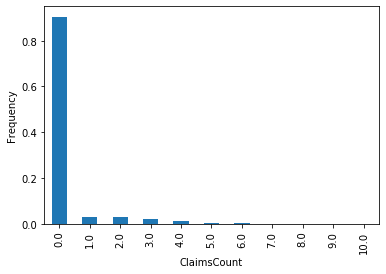

In [45]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [46]:
FreqCount

,Count,Freq
ClaimsCount,,
0.0,104286,0.905614
1.0,3339,0.028996
2.0,3529,0.030646
3.0,2310,0.020060
4.0,1101,0.009561
5.0,428,0.003717
6.0,127,0.001103
7.0,26,0.000226
8.0,6,0.000052


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец weight. Присвоим ему некоторые значения, например, можно задать 0.05 для значений ClaimsCount 0, а для остальных - 1 (Для этого можем использовать функцию np.where). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [48]:
df['weight'] = np.where(df['ClaimsCount'] < 1, 0.05, 1)

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [52]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimsCount'], axis=1), df.ClaimsCount, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты DMatrix для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр weight равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр data.

In [53]:
xgb_train = xgb.DMatrix(data=x_train.drop(['weight'], axis=1), label=y_train, weight=x_train['weight'])
xgb_valid = xgb.DMatrix(data=x_valid.drop(['weight'], axis=1), label=y_valid, weight=x_valid['weight'])
xgb_test  = xgb.DMatrix(data= x_test.drop(['weight'], axis=1), label=y_test, weight=x_test['weight'])

In [28]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train = xgb.DMatrix(x_train, y_train)
valid = xgb.DMatrix(x_valid, y_valid)
test = xgb.DMatrix(x_test, y_test)

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [113]:
# Зададим функцию Deviance для распределения Пуассона

def xgb_eval_dev_poisson(yhat, y):
    t_hat, t = yhat + 1, y.get_label() + 1
    return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))

In [114]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [116]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {
    'data': xgb_train,
    'objective': 'multi:softmax',
    'num_class': 11,
    'eval_metric': 'mlogloss',
    'maximize': False,
    'nfold': 5,
    'early_stopping_rounds': 20,
    'num_boost_round': 300,  # hp.choice('num_boost_round', [50, 300, 500])
    'max_depth': hp.choice('max_depth', [5, 8, 10, 20, 40]),
    'min_child_weight': hp.uniform('min_child_weight', 0, 50),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'alpha': hp.uniform('alpha', 0, 1),
    'lambda': hp.uniform('lambda', 0, 1),
    'eta': hp.uniform('eta', 0.01, 1),
}

In [ ]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_poisson,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [ ]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'objective': 'count:poisson',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              'tree_method': 'hist'
              }

In [ ]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_c),
            space=space_freq, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

In [84]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.21288496257449918,
 'colsample_bytree': 0.8059568157492036,
 'eta': 0.5006846049474015,
 'lambda': 0.09973544302783155,
 'max_depth': 0,
 'min_child_weight': 13.637108730935509,
 'subsample': 0.6229369552625339}

In [ ]:
train_params = {'num_boost_round': 300,
                'feval': xgb_eval_dev_poisson,
                'maximize': False,
                'verbose_eval': False}

Далее обучим нашу модель с оптимальными параметрами

In [93]:
progress_wo_es = dict()
xgb_freq_wo_es = xgb.train(params=best_params, dtrain=train_c, evals=[(train_c, "train"), (valid_c, "valid"), (test_c, "test")],
                           evals_result=progress_wo_es, **train_params)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью plt.imshow(). Можно использовать предложенный ниже код.


In [111]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(list(dfset['target']), class_preds, average='micro')) # Посчитаем F1 Score

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [106]:
y_train

63589     0.0
84545     0.0
96009     0.0
25437     0.0
37102     0.0
         ... 
93553     0.0
50496     0.0
94735     0.0
105597    0.0
83209     0.0
Name: ClaimsCount, Length: 80608, dtype: float64